In [16]:
#Reference: https://pypi.org/project/text-hammer/

#!pip install text-hammer
#!pip install spacy
#!python -m spacy download en_core_web_sm
#!pip install ipywidgets
#!jupyter nbextension enable --py widgetsnbextension
#!pip install lxml

#!pip install nltk
#PLEASE DO NOT RUN THE FOLLOWING download() command at Jupyter. Run in a terminal.
#nltk.download()
### select 'all' 

#!pip install wordcloud


In [58]:
# Loading Essential libraries 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm._tqdm_notebook import tqdm_notebook
import text_hammer as th
import nltk

from wordcloud import WordCloud
import wordcloud

from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences


from keras.models import Sequential 
from keras.layers import Dense, LSTM, Embedding,Bidirectional
import tensorflow
from keras.layers import CuDNNLSTM,CuDNNGRU
from keras.layers import Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint

import gensim.downloader as api

from sklearn import metrics




In [ ]:
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'  #to enforce plot format to be in high resolution
%config Completer.use_jedi = False # this to force autocompletion 

In [3]:
df = pd.read_csv('../datasets/SPAM text message 20170820 - Data.csv')
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [5]:
df.shape

(5572, 2)

In [6]:
# convert label to a numerical variable
df['Category'] = df.Category.map({'ham':0, 'spam':1})
df.head()

,Category,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


### Plots about the dataset


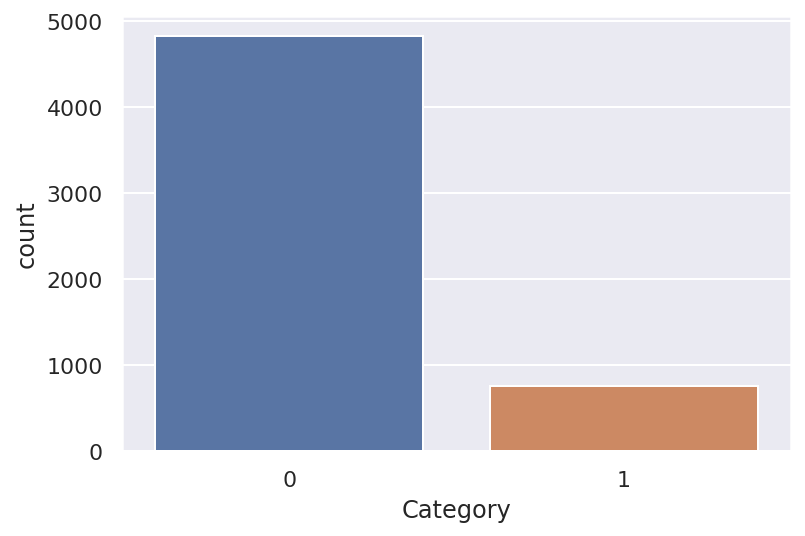

In [8]:
sns.set()
sns.countplot(df.Category)
plt.show()

In [9]:
df['word_length'] = df['Message'].apply(lambda x:len(x.split()))

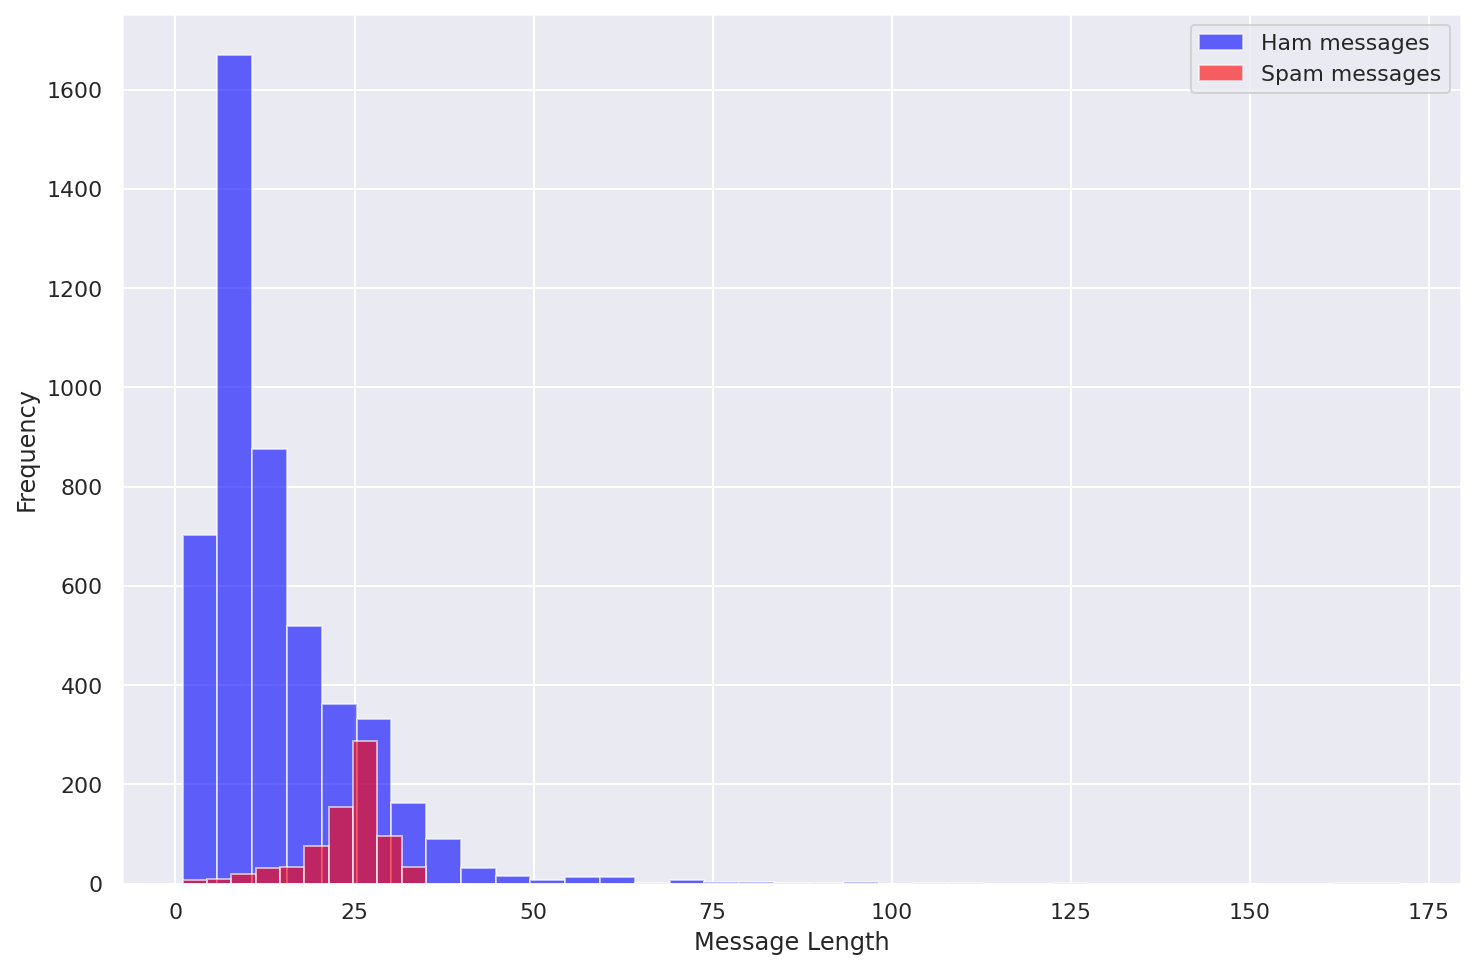

In [10]:
plt.figure(figsize=(12, 8))

df[df.Category==0].word_length.plot(bins=35, kind='hist', color='blue', 
                                       label='Ham messages', alpha=0.6)
df[df.Category == 1].word_length.plot(kind='hist', color='red', 
                                       label='Spam messages', alpha=0.6)
plt.legend()
plt.xlabel("Message Length")
plt.show()

In [11]:
df.groupby('Category').mean()

,word_length
Category,
0,14.310259
1,23.812584


In [12]:
# describing the hame(normal msgs )
df[df.Category == 0].describe()

,Category,word_length
count,4825.0,4825.000000
mean,0.0,14.310259
std,0.0,11.517945
min,0.0,1.000000
25%,0.0,7.000000
50%,0.0,11.000000
75%,0.0,19.000000
max,0.0,171.000000


In [13]:
# Describing  the spam msgs
df[df.Category == 1].describe()

,Category,word_length
count,747.0,747.000000
mean,1.0,23.812584
std,0.0,5.956923
min,1.0,1.000000
25%,1.0,22.000000
50%,1.0,25.000000
75%,1.0,28.000000
max,1.0,35.000000


**From here we can say that the longer texts are more probable to become Spam

### Text preprocessing

In [18]:
%%time

tqdm_notebook.pandas()

def text_preprocessing(df,col_name):
    column = col_name
    df[column] = df[column].progress_apply(lambda x:str(x).lower())
    df[column] = df[column].progress_apply(lambda x: th.cont_exp(x)) #you're -> you are; i'm -> i am
    df[column] = df[column].progress_apply(lambda x: th.remove_emails(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_html_tags(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_stopwords(x))
    #Spelling correction takes time! But, with small data, you can do it.
#     df[column] = df[column].progress_apply(lambda x:th.spelling_correction(x))
  
    df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.make_base(x)) #ran -> run,
    return(df)

CPU times: user 852 µs, sys: 225 µs, total: 1.08 ms
Wall time: 799 µs


In [19]:
cleaned_df = text_preprocessing(df, "Message")

  0%|          | 0/5572 [00:00<?, ?it/s]

  0%|          | 0/5572 [00:00<?, ?it/s]

  0%|          | 0/5572 [00:00<?, ?it/s]

  0%|          | 0/5572 [00:00<?, ?it/s]

  0%|          | 0/5572 [00:00<?, ?it/s]

  0%|          | 0/5572 [00:00<?, ?it/s]

  0%|          | 0/5572 [00:00<?, ?it/s]

  0%|          | 0/5572 [00:00<?, ?it/s]

In [20]:
cleaned_df.Message

0       jurong point crazy available bugis great world...
1                                   ok lar joking wif oni
2       free entry 2 wkly comp win fa cup final tkts 2...
3                                     dun early hor c say
4                                   nah think go usf life
                              ...                        
5567    2nd time try 2 contact you win 750 pound prize...
5568                             u b go esplanade fr home
5569                      pity mood that soany suggestion
5570    guy bitching act like interested buying week g...
5571                                roll floor laugh true
Name: Message, Length: 5572, dtype: object

## EDA

In [23]:
### Calculating the word frequency by using nltk
words_list = []
for sentence in cleaned_df.Message:
    words_list.extend(nltk.word_tokenize(sentence))
freq_dist = nltk.FreqDist(words_list)
freq_dist.most_common(20)
# freq_dist.keys()

[('2', 481),
 ('you', 453),
 ('not', 415),
 ('go', 335),
 ('come', 325),
 ('I', 300),
 ('4', 293),
 ('do', 290),
 ('know', 287),
 ('get', 283),
 ('ok', 278),
 ('free', 276),
 ('good', 275),
 ('send', 273),
 ('like', 254),
 ('want', 242),
 ('day', 242),
 ('time', 236),
 ('love', 232),
 ('now', 231)]

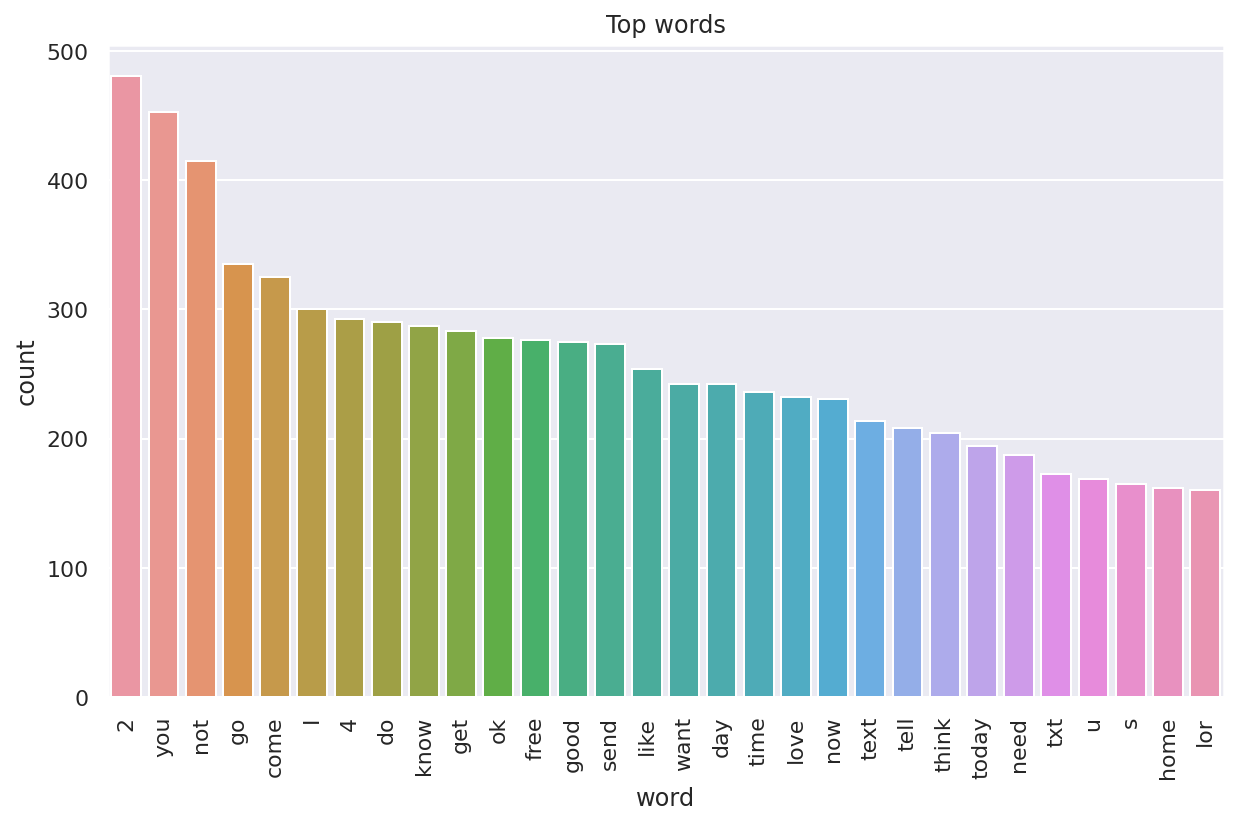

In [24]:
temp = pd.DataFrame(freq_dist.most_common(30),  columns=['word', 'count'])
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='word', y='count', 
            data=temp, ax=ax)
plt.title("Top words")
plt.xticks(rotation='vertical');

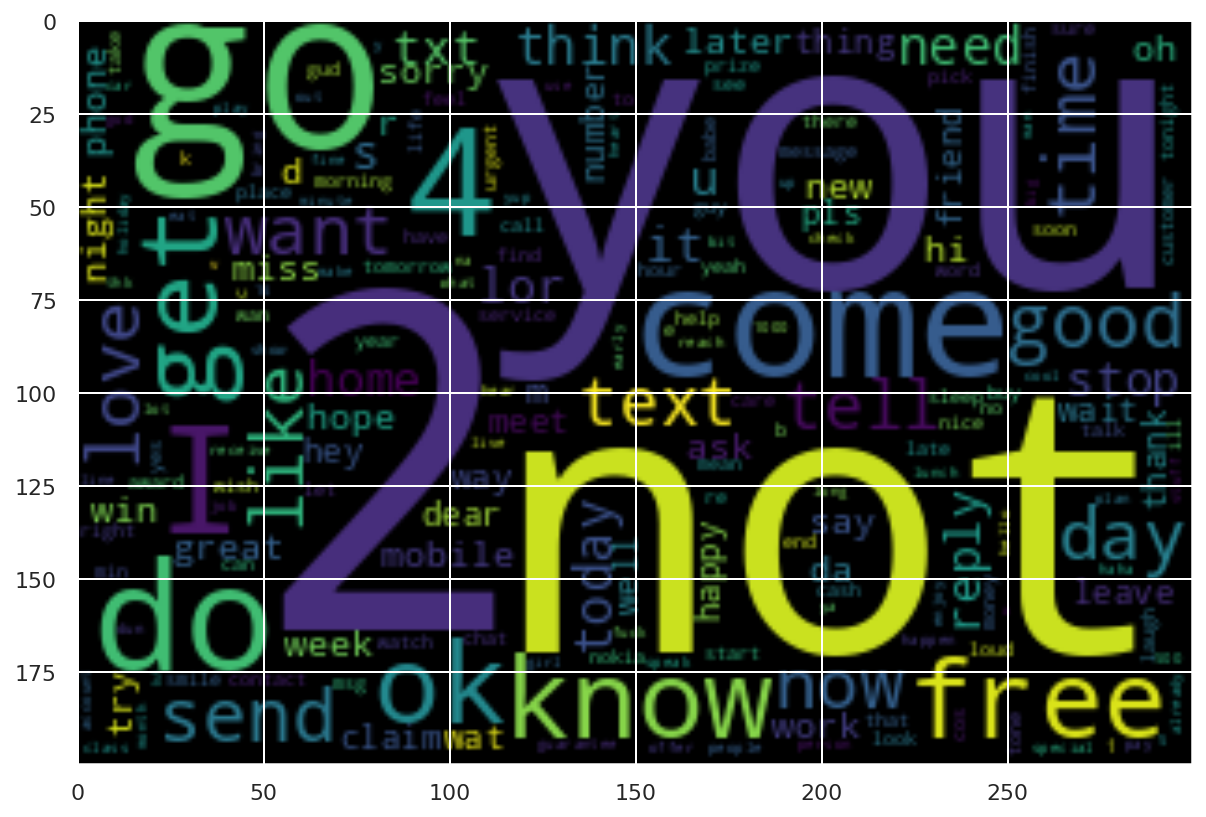

In [26]:
### Creating wordcloud
wcloud_fig = WordCloud( stopwords=set(wordcloud.STOPWORDS),
                      colormap='viridis', width=300, height=200).generate_from_frequencies(freq_dist)

# plotting the wordcloud
plt.figure(figsize=(10,7), frameon=True)

plt.imshow(wcloud_fig, interpolation  = 'bilinear')
plt.show()

### Module 2 
#### till now we have done all text cleaning and plotting part 

#### now lets split our data for some training and testing 

In [28]:
#Use the `stratify` option to keep the target distribution same in the splits
X_train,X_test, y_train,y_test = train_test_split(cleaned_df.Message, cleaned_df.Category, test_size = 0.2, stratify = cleaned_df.Category,random_state = 42)

### Using The tokenizer Class to convert the sentences into word vectors¶


In [30]:
num_words = 10000 # this means 15000 unique words can be taken 
tokenizer=Tokenizer(num_words,lower=True)
df_total = pd.concat([X_train, X_test], axis = 0)
tokenizer.fit_on_texts(df_total)


In [31]:
len(tokenizer.word_index) # this is whole unique words in our corpus
# but we have taken 10000 but we have only 8502 and the rest will be zero

8400

In [32]:
cleaned_df.word_length.max()

171

In [34]:
X_train_ =tokenizer.texts_to_sequences(X_train)
X_train_pad=pad_sequences(X_train_,maxlen=171,padding='post') #post/pre --adding zeros after/before the sequence
X_test_ = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_, maxlen = 171, padding = 'post')


In [35]:
print(X_train_pad.shape,X_test_pad.shape) # this is our 2D matrix we can take this as Input data

(4457, 171) (1115, 171)


### Now lets design our Deep learning model to train our data

### Method1: by using solely embedding layers

In [37]:
EMBEDDING_DIM = 100 # this means the embedding layer will create  a vector in 100 dimension
model = Sequential()
model.add(Embedding(input_dim = num_words,# the whole vocabulary size 
                          output_dim = EMBEDDING_DIM, # vector space dimension
                          input_length= X_train_pad.shape[1] # max_len of text sequence
                          ))
model.add(Dropout(0.2))
model.add(Bidirectional(CuDNNLSTM(100,return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(CuDNNLSTM(200,return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(CuDNNLSTM(100,return_sequences=False)))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam',metrics = 'accuracy')

2022-07-28 11:36:30.077791: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-28 11:36:30.078820: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-28 11:36:30.079194: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-28 11:36:30.079481: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [39]:
#EarlyStopping and ModelCheckpoint
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 10)
mc = ModelCheckpoint('../model_files/model.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

In [40]:
history_embedding = model.fit(X_train_pad,y_train, epochs = 35, batch_size = 120, validation_data=(X_test_pad, y_test),verbose = 1, callbacks= [es, mc]  )


Epoch 1/35


2022-07-28 11:37:10.570388: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


38/38 [==============================] - ETA: 0s - loss: 0.3158 - accuracy: 0.8945
Epoch 1: val_accuracy improved from -inf to 0.96413, saving model to ../model_files/model.h5
38/38 [==============================] - 10s 132ms/step - loss: 0.3158 - accuracy: 0.8945 - val_loss: 0.1298 - val_accuracy: 0.9641
Epoch 2/35
38/38 [==============================] - ETA: 0s - loss: 0.0533 - accuracy: 0.9865
Epoch 2: val_accuracy improved from 0.96413 to 0.98386, saving model to ../model_files/model.h5
38/38 [==============================] - 4s 112ms/step - loss: 0.0533 - accuracy: 0.9865 - val_loss: 0.0583 - val_accuracy: 0.9839
Epoch 3/35
38/38 [==============================] - ETA: 0s - loss: 0.0164 - accuracy: 0.9966
Epoch 3: val_accuracy improved from 0.98386 to 0.98475, saving model to ../model_files/model.h5
38/38 [==============================] - 4s 111ms/step - loss: 0.0164 - accuracy: 0.9966 - val_loss: 0.0609 - val_accuracy: 0.9848
Epoch 4/35
38/38 [==============================] 

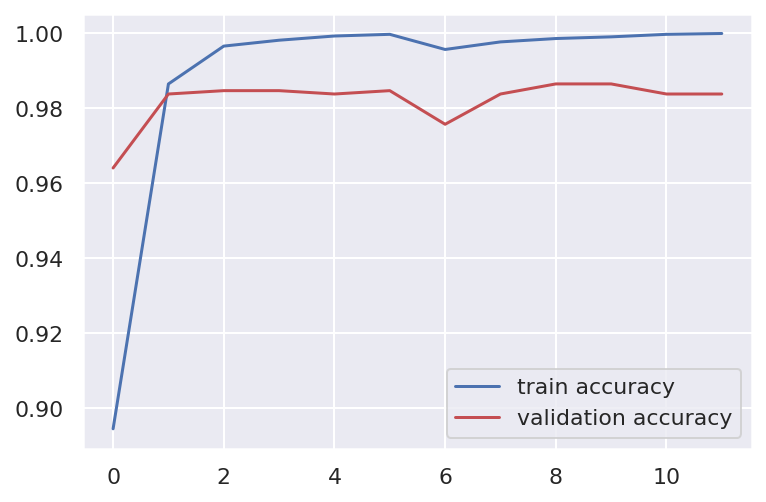

In [41]:
plt.plot(history_embedding.history['accuracy'],c='b',label='train accuracy')
plt.plot(history_embedding.history['val_accuracy'],c='r',label='validation accuracy')
plt.legend(loc='lower right')
plt.show()


#### the maximum accuracy we got with wordembedding is 98 with some overfitting 
- now we would try with word2vec

### Method 2: Using word2vec **i'm gonna use gensim **

In [43]:
glove_gensim  = api.load('glove-wiki-gigaword-100') # this would download vector with 100 dimension

In [44]:
glove_gensim['cat'].shape[0] # this is the dimension of the vectors

100

In [46]:
glove_gensim.index_to_key

['the',
 ',',
 '.',
 'of',
 'to',
 'and',
 'in',
 'a',
 '"',
 "'s",
 'for',
 '-',
 'that',
 'on',
 'is',
 'was',
 'said',
 'with',
 'he',
 'as',
 'it',
 'by',
 'at',
 '(',
 ')',
 'from',
 'his',
 "''",
 '``',
 'an',
 'be',
 'has',
 'are',
 'have',
 'but',
 'were',
 'not',
 'this',
 'who',
 'they',
 'had',
 'i',
 'which',
 'will',
 'their',
 ':',
 'or',
 'its',
 'one',
 'after',
 'new',
 'been',
 'also',
 'we',
 'would',
 'two',
 'more',
 "'",
 'first',
 'about',
 'up',
 'when',
 'year',
 'there',
 'all',
 '--',
 'out',
 'she',
 'other',
 'people',
 "n't",
 'her',
 'percent',
 'than',
 'over',
 'into',
 'last',
 'some',
 'government',
 'time',
 '$',
 'you',
 'years',
 'if',
 'no',
 'world',
 'can',
 'three',
 'do',
 ';',
 'president',
 'only',
 'state',
 'million',
 'could',
 'us',
 'most',
 '_',
 'against',
 'u.s.',
 'so',
 'them',
 'what',
 'him',
 'united',
 'during',
 'before',
 'may',
 'since',
 'many',
 'while',
 'where',
 'states',
 'because',
 'now',
 'city',
 'made',
 'like',
 

In [48]:
# now lets connvert all the words we have in our data into vectors 
vector_size = 100
gensim_weight_matrix = np.zeros((num_words ,vector_size))
gensim_weight_matrix.shape

for word, index in tokenizer.word_index.items():
    if index < num_words: # since index starts with zero 
        if word in glove_gensim.index_to_key:
            gensim_weight_matrix[index] = glove_gensim[word]
        else:
            gensim_weight_matrix[index] = np.zeros(100)

In [49]:
gensim_weight_matrix.shape

(10000, 100)

In [50]:
# designing our architecture 
EMBEDDING_DIM = 100 # this means the embedding layer will create  a vector in 100 dimension
model_gensim = Sequential()
model_gensim.add(Embedding(input_dim = num_words,# the whole vocabulary size 
                          output_dim = EMBEDDING_DIM, # vector space dimension
                          input_length= X_train_pad.shape[1], # max_len of text sequence
                          weights = [gensim_weight_matrix],trainable = False))
model_gensim.add(Dropout(0.2))
model_gensim.add(Bidirectional(CuDNNLSTM(100,return_sequences=True)))
model_gensim.add(Dropout(0.2))
model_gensim.add(Bidirectional(CuDNNLSTM(200,return_sequences=True)))
model_gensim.add(Dropout(0.2))
model_gensim.add(Bidirectional(CuDNNLSTM(100,return_sequences=False)))
model_gensim.add(Dense(1, activation = 'sigmoid'))
model_gensim.compile(loss = 'binary_crossentropy', optimizer = 'adam',metrics = 'accuracy')

In [51]:
model_gensim.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 171, 100)          1000000   
                                                                 
 dropout_3 (Dropout)         (None, 171, 100)          0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 171, 200)         161600    
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 171, 200)          0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 171, 400)         643200    
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 171, 400)         

In [52]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
mc = ModelCheckpoint('../model_files/model_gensim.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

In [53]:
history_gensim = model_gensim.fit(X_train_pad,y_train, epochs = 25, batch_size = 120, validation_data=(X_test_pad, y_test),verbose = 1, callbacks= [es, mc]  )


Epoch 1/25
38/38 [==============================] - ETA: 0s - loss: 0.2691 - accuracy: 0.9179
Epoch 1: val_accuracy improved from -inf to 0.93722, saving model to ../model_files/model_gensim.h5
38/38 [==============================] - 7s 130ms/step - loss: 0.2691 - accuracy: 0.9179 - val_loss: 0.1679 - val_accuracy: 0.9372
Epoch 2/25
38/38 [==============================] - ETA: 0s - loss: 0.1271 - accuracy: 0.9587
Epoch 2: val_accuracy improved from 0.93722 to 0.95695, saving model to ../model_files/model_gensim.h5
38/38 [==============================] - 4s 109ms/step - loss: 0.1271 - accuracy: 0.9587 - val_loss: 0.1283 - val_accuracy: 0.9570
Epoch 3/25
38/38 [==============================] - ETA: 0s - loss: 0.1013 - accuracy: 0.9668
Epoch 3: val_accuracy improved from 0.95695 to 0.95785, saving model to ../model_files/model_gensim.h5
38/38 [==============================] - 4s 110ms/step - loss: 0.1013 - accuracy: 0.9668 - val_loss: 0.1074 - val_accuracy: 0.9578
Epoch 4/25
38/38 [=

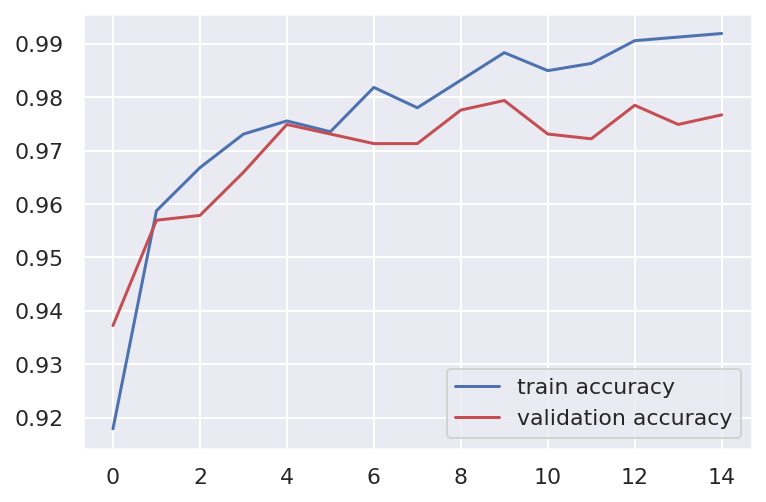

In [54]:
# lets draw learning curve 

plt.plot(history_gensim.history['accuracy'],c='b',label='train accuracy')
plt.plot(history_gensim.history['val_accuracy'],c='r',label='validation accuracy')
plt.legend(loc='lower right')
plt.show()


### **model trained with word2vec is a more generalized model, so we will choose that as our final model **

In [55]:
model_gensim.evaluate(X_test_pad, y_test) 


35/35 [==============================] - 1s 26ms/step - loss: 0.0876 - accuracy: 0.9767


[0.08755489438772202, 0.9766815900802612]

In [56]:
model.evaluate(X_test_pad, y_test)

35/35 [==============================] - 1s 23ms/step - loss: 0.1094 - accuracy: 0.9839


[0.10938862711191177, 0.9838564991950989]

### Model Evaluation

In [57]:
y_pred = np.where(model.predict(X_test_pad)>.5,1,0)

35/35 [==============================] - 1s 22ms/step


In [59]:
print(metrics.classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       976
           1       0.91      0.97      0.94       139

    accuracy                           0.98      1115
   macro avg       0.95      0.98      0.96      1115
weighted avg       0.98      0.98      0.98      1115



In [60]:
y_pred_gensim = np.where(model_gensim.predict(X_test_pad)>0.5,1,0)
print(metrics.classification_report(y_pred_gensim, y_test))

35/35 [==============================] - 1s 23ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       964
           1       0.92      0.91      0.91       151

    accuracy                           0.98      1115
   macro avg       0.95      0.95      0.95      1115
weighted avg       0.98      0.98      0.98      1115



### Now lets test our model with real data

In [61]:
def predict(sentence):
    sentence_lst=[]
    sentence_lst.append(sentence)
    sentence_seq=tokenizer.texts_to_sequences(sentence_lst)
    sentence_padded=pad_sequences(sentence_seq,maxlen=171,padding='post')
    probability = (model_gensim.predict(sentence_padded))[0][0]
    if probability > 0.5:
        print(f'Spam | {np.round(probability*100,2)}%')
    else:
        print(f'Normal | {100 - (np.round(probability*100,2))}%')


In [ ]:
#predict(str(input('Enter the Sentence:')))

In [ ]:
#predict(str(input('Enter the Sentence:')))

In [66]:
predict('invoice of amount $1000 check')

1/1 [==============================] - 0s 18ms/step
Spam | 70.33%
